In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2

In [2]:

train_dir = "C:/Users/miche/Documents/M2/RF_Projet/fer2013/test/"
test_dir = "C:/Users/miche/Documents/M2/RF_Projet/fer2013/train/"

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train    958      111  1024   1774     1233  1247       831
      angry  disgust  fear  happy  neutral   sad  surprise
test   3995      436  4097   7215     4965  4830      3171


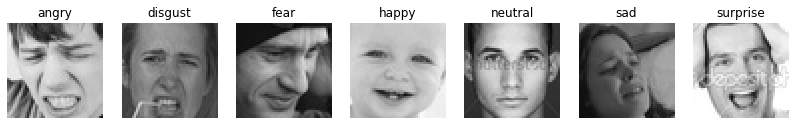

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[10]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [6]:
#Creating Training and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 7178 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [18]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [19]:
#Defining Model
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [20]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 256)      

In [18]:
#Callbacks Function
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [19]:
#Training Model
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=200,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/200
112/112 [==============================] - 8917s 80s/step - loss: 14.4603 - accuracy: 0.2124 - val_loss: 24.1667 - val_accuracy: 0.0152

Epoch 00001: val_loss improved from inf to 24.16670, saving model to ferNet.h5
Epoch 2/200
112/112 [==============================] - 43s 388ms/step - loss: 12.4682 - accuracy: 0.2544 - val_loss: 22.4883 - val_accuracy: 0.0152

Epoch 00002: val_loss improved from 24.16670 to 22.48832, saving model to ferNet.h5
Epoch 3/200
112/112 [==============================] - 43s 383ms/step - loss: 11.9175 - accuracy: 0.2755 - val_loss: 17.5324 - val_accuracy: 0.0152

Epoch 00003: val_loss improved from 22.48832 to 17.53238, saving model to ferNet.h5
Epoch 4/200
112/112 [==============================] - 43s 384ms/step - loss: 11.2802 - accuracy: 0.2999 - val_loss: 12.9577 - val_accuracy: 0.1147

Epoch 00004: val_loss improved from 17.53238 to 12.95775, saving model to ferNet.h5
Epoch 5/200
112/112 [==============================] - 43s 383ms/step - l

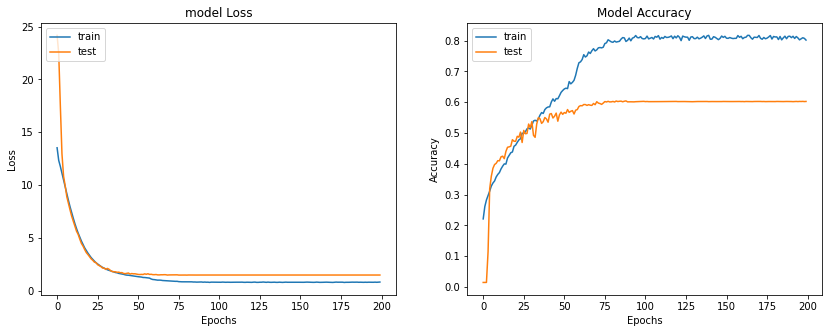

In [20]:
#Loss and Accuracy plot
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
#Model evaluation
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 [==============================] - 35s 77ms/step - loss: 1.4907 - accuracy: 0.6023
final train accuracy = 89.09 , validation accuracy = 60.23


In [23]:
fernet.save_weights('fernet_bestweight.h5')
fernet.save_model('model.h5')

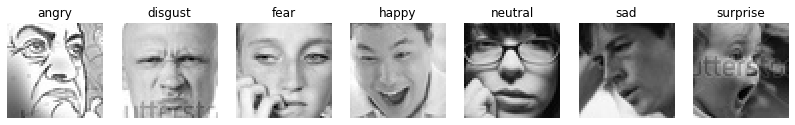

In [21]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(test_dir):
    img = load_img((test_dir + expression +'/'+ os.listdir(test_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

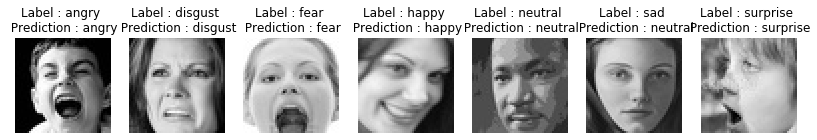

In [22]:
# classes labels
labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

test_dir = "C:/Users/miche/Documents/M2/RF_Projet/fer2013/test/"

plt.figure(figsize=(14,22))
i = 1

# load model
model = tf.keras.models.load_model("ferNet.h5")
    
for expression in os.listdir(test_dir):
    img = cv2.imread(test_dir + expression +'/'+ os.listdir(test_dir + expression)[20])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (48,48))
    gray = gray.reshape(1, gray.shape[0], gray.shape[1], 1)
    gray = gray/255
    
     # emotion predicted
    pred = model.predict(gray)
    # get the candidate classe
    id_max = np.argmax(pred)
    pred_label = labels[id_max]
    
    plt.subplot(1,7,i)
    
    plt.imshow(img)
    plt.title('Label : {} \n Prediction : {}'.format(expression, pred_label))
    plt.axis('off')
    i += 1
plt.show()

In [23]:
# classes labels
labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

def predict_emotion_on_img(img_path):
    img = cv2.imread(img_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # load detector
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # load model
    model = tf.keras.models.load_model("ferNet.h5")
    
    # face detection
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
        drop_face = gray[y:y+h, x:x+w]
        drop_face = cv2.resize(drop_face, (48,48))
        drop_face = drop_face.reshape(1, drop_face.shape[0], drop_face.shape[1], 1)
        
        drop_face = drop_face/255

        # emotion predicted
        pred = model.predict(drop_face)

        # get the candidate classe
        id_max = np.argmax(pred)

        pred_label = labels[id_max]

        #print(pred,'\n')
        #cv2.putText(img,pred_label,(x ,y -15), cv2.FONT_HERSHEY_SIMPLEX,1 , (0,0,255))
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (0, 0, 255)
        thickness = 2
        cv2.putText(img, pred_label, (x ,y -15), font,  
                   fontScale, color, thickness, cv2.LINE_AA) 

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.show()

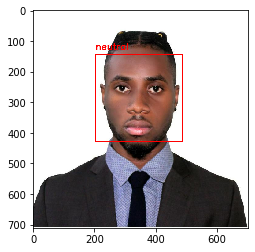

In [24]:
predict_emotion_on_img("image_quelconque/neutre.jpeg")

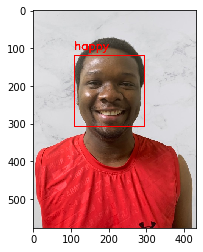

In [25]:
predict_emotion_on_img("image_quelconque/happy.jpg")

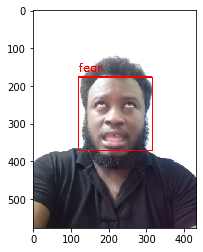

In [15]:
predict_emotion_on_img("image_quelconque/fear.jpg")

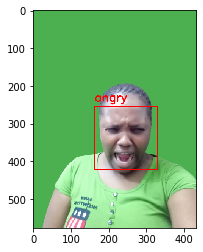

In [16]:
predict_emotion_on_img("image_quelconque/angry.jpg")

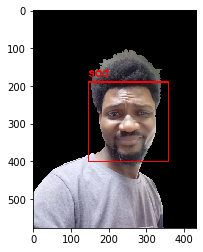

In [17]:
predict_emotion_on_img("image_quelconque/sad.png")

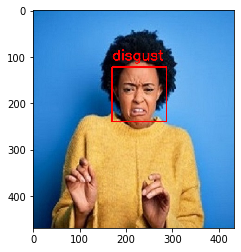

In [18]:
predict_emotion_on_img("image_quelconque/distgust.jpg")

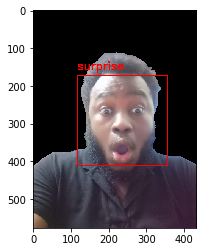

In [16]:
predict_emotion_on_img("image_quelconque/surprise.png")

In [17]:
import cv2
import numpy as np
import tensorflow as tf
import urllib

print(tf.__version__)

# set video source (camera :0, video, webcam mobile address)
url='http://192.168.137.86:8080/shot.jpg'

# load detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# load model
model = tf.keras.models.load_model("ferNet.h5")

# classes labels
labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

# set video source (camera :0, video, webcam mobile address)
VIDEO_PATH = 0
vs = cv2.VideoCapture(VIDEO_PATH)

# we will chech frame at position % 5 = 0
count_frame = 0
while vs.isOpened():
    #_bool, frame = vs.read()
    imgResp=urllib.request.urlopen(url);
    imgNp=np.array(bytearray(imgResp.read()),dtype=np.uint8)
    frame=cv2.imdecode(imgNp,-1)
    
    if frame is None:
        print('Erreur lecture de la vidéo')
        break
    if count_frame%15 == 0:
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
            drop_face = gray[y:y+h, x:x+w]
            img = cv2.resize(drop_face, (48,48))
            img = img.reshape(1, img.shape[0], img.shape[1], 1)
            
            #image scale
            img = img/255
            # emotion predicted
            pred = model.predict(img)
            
            # get the candidate classe
            id_max = np.argmax(pred)
            
            pred_label = labels[id_max]
            
            #print(pred,'\n')
            cv2.putText(frame,pred_label,(x ,y -15), cv2.FONT_HERSHEY_SIMPLEX, 1, (200,255,155))
        
        cv2.imshow("Stream Live Emotion detected", frame)
    
    count_frame += 1
    # q to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vs.release()
cv2.destroyAllWindows()

2.4.1


In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = fernet.predict(test_set)
labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

sns.heatmap(confusion_matrix(pred_label, y_pred), annot=True, xticklabels=set(y_train), yticklabels=set(y_train))
#plt.ylabel('pred_label')
plt.xlabel('labels')
plt.show()

In [ ]:
#Confusion Matrix and Classification on test set
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)